In [1]:
import matplotlib.pyplot as plt
import colorcet
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.postprocess import CmosReflectance
from pyeosim.spectral import Sentinel2VNIR
from pyeosim.sensor import TeledyneCMOS
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
rgb_image = rgb(im.isel(band=[70,40,20]), return_array=True)
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

In [95]:
cmos = TeledyneCMOS(adc_gain=1e5, store_steps=False,
                    TDI_rows=32, psf_fwhm=2)
demo = cmos.fit_transform(TOA)
# cmos.get_params()

Text(0.5, 0, 'Wavelength (nm)')

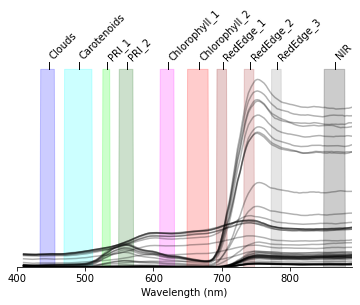

In [96]:
srf = cmos.spectral_response
ymax = .75
band_cols = ['blue', 'aqua', 'lime', 'darkgreen', 'magenta', 'red', 'darkred','brown','grey', 'k']
for n, c in zip(srf.band_names, band_cols):
#     srf.srfs[n].plot(c=c, label=n,)
    plt.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.2)
plt.ylim(.01,ymax*1.1)
plt.xlim(400,890)
# plt.legend()

for wlen, name in zip(srf.band_wavelengths.values(), srf.band_names):
    plt.annotate(name, (wlen,ymax*1.05), rotation=45)
    plt.annotate('I', (wlen,ymax*1), rotation=0)

im_ref.isel(y=200, x=slice(30,80)).plot(hue='x', c='k', alpha=.3, add_legend=False,)
plt.title('')
sns.despine(left=True)
plt.yticks([])
plt.ylabel('')
plt.xlim(400,890)
plt.xlabel('Wavelength (nm)')

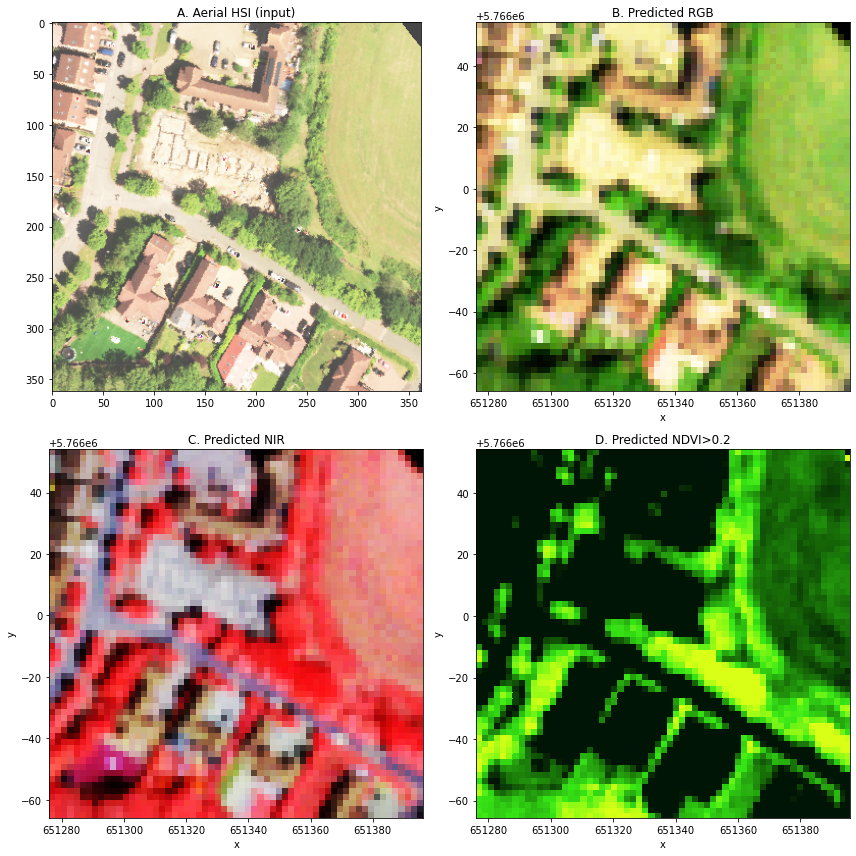

In [97]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA)
BOA = cmos_pipe.transform(TOA)
# # write latex table of parameters
cmos.steps_to_latex('outputs/cmos.tex')
# # generate reference and signal arrays
# calculate some composites
bgr = BOA.isel(band=[5,3,0]) * [.4,.7,1]
nir = BOA.isel(band=[9,6,3])
ndvi = ((BOA.isel(band=9) - BOA.isel(band=5))/(BOA.isel(band=9) + BOA.isel(band=5)))
# plot
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0][0].imshow(rgb_image)
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, vmin=.1, robust=True, cmap=colorcet.cm.kgy)
ax[1][1].set_title('D. Predicted NDVI>0.2')
plt.tight_layout()

In [98]:
from pyeosim._decorators import return_equal_xarray
import functools

In [99]:
from pyeosim._decorators import sklearn_pixelwise
@sklearn_pixelwise
def fit_transform(arr, cluster):
    return cluster.fit_transform(arr)
@sklearn_pixelwise
def fit_predict(arr, cluster):
    return cluster.fit_predict(arr)


In [110]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import cluster
from sklearn import decomposition

cluster_pipe = Pipeline([('scale', RobustScaler()),
                         ('cluster', cluster.SpectralClustering(6))])

decompos_pipe = Pipeline([('scale', RobustScaler()),
                         ('decompose', decomposition.PCA(2))])

In [111]:
im = xarray.open_dataset(fpath).Reflectance

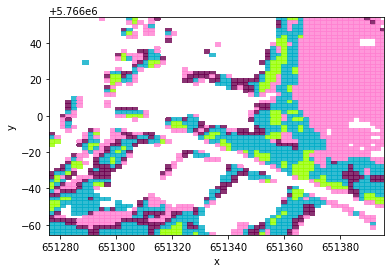

In [112]:
a = fit_predict(BOA.where(ndvi>.25), cluster_pipe)
a.plot(levels=5, colors=colorcet.glasbey_bw[3:10], add_colorbar=False, alpha=.8)

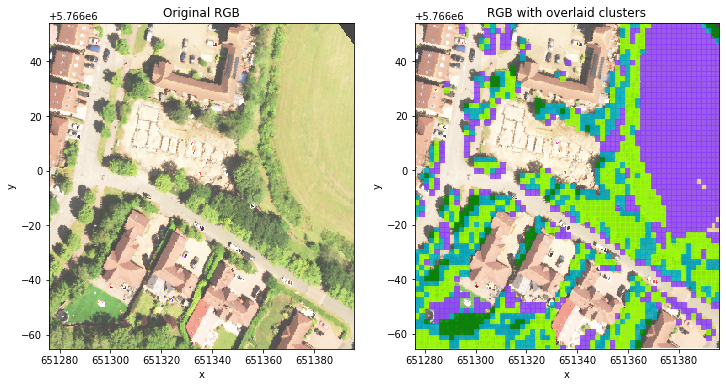

In [113]:
a = fit_predict(BOA.where(ndvi>.2), cluster_pipe)
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
rgb(im.isel(band=[70,40,20]), ax=ax[1])
rgb(im.isel(band=[70,40,20]), ax=ax[0])
a.plot(levels=5, colors=colorcet.glasbey_bw[1:5], add_colorbar=False, ax=ax[1], alpha=.8)
ax[0].set_title('Original RGB')
ax[1].set_title('RGB with overlaid clusters')
plt.savefig('outputs/TreeView_clustering.png', dpi=200)

In [153]:
cluster_pipe2 = Pipeline([('scale', RobustScaler()),
                         ('cluster', cluster.SpectralClustering(7))])

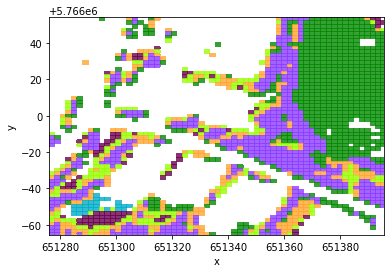

In [158]:
a2 = fit_predict(BOA.where(ndvi>.25), cluster_pipe2)
a2.plot(levels=9, colors=colorcet.glasbey_bw[1:8], add_colorbar=False, alpha=.8)

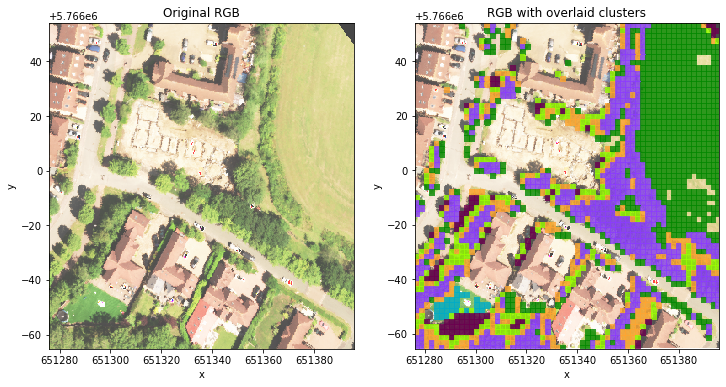

In [159]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
rgb(im.isel(band=[70,40,20]), ax=ax[1])
rgb(im.isel(band=[70,40,20]), ax=ax[0])
a2.plot(levels=9, colors=colorcet.glasbey_bw[1:8], add_colorbar=False, ax=ax[1], alpha=.8)
ax[0].set_title('Original RGB')
ax[1].set_title('RGB with overlaid clusters')
plt.savefig('outputs/TreeView_clustering2.png', dpi=200)

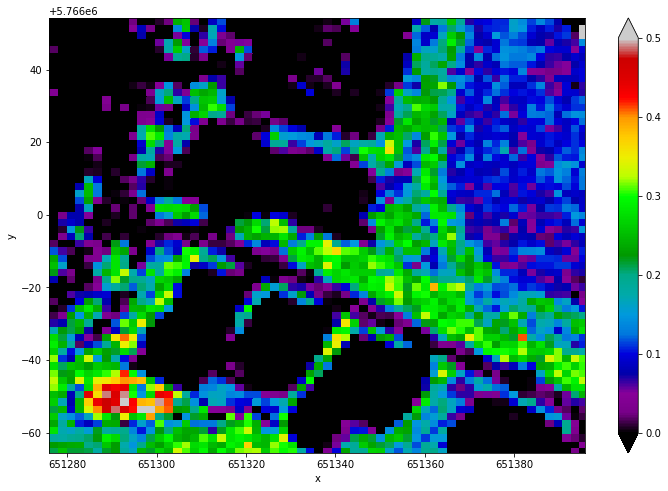

In [178]:
((BOA.isel(band=3) - BOA.isel(band=4))/(BOA.isel(band=4) + BOA.isel(band=3))).plot(
    vmin=0,vmax=.5,cmap='nipy_spectral', robust=True, size = 8)
plt.savefig('outputs/TreeView_PRI.png', dpi=200)